#### Required libraries

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import threading
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

### Visualization

Open the train dataset and start to explore about it <br>
train data have labels and test data do not have


In [110]:
train_file_path = 'train.csv'
test_file_path = 'test.csv'
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)
print(train_df.shape)
print(test_df.shape)

(381109, 12)
(127037, 11)


In [111]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127037 entries, 0 to 127036
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    127037 non-null  int64  
 1   Gender                127037 non-null  object 
 2   Age                   127037 non-null  int64  
 3   Driving_License       127037 non-null  int64  
 4   Region_Code           127037 non-null  float64
 5   Previously_Insured    127037 non-null  int64  
 6   Vehicle_Age           127037 non-null  object 
 7   Vehicle_Damage        127037 non-null  object 
 8   Annual_Premium        127037 non-null  float64
 9   Policy_Sales_Channel  127037 non-null  float64
 10  Vintage               127037 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 10.7+ MB


In [112]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


There are no missing values in my data

Feature explanation:

**id**	 Unique ID for the customer <br>
**Gender**	 Gender of the customer <br>
**Age**	 Age of the customer <br>
**Driving_License**	 0 : Customer does not have DL, 1 : Customer already has DL <br>
**Region_Code**	 Unique code for the region of the customer <br>
**Previously_Insured**	 1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance <br>
**Vehicle_Age**	 Age of the Vehicle <br>
**Vehicle_Damage**	 1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past. <br>
**Annual_Premium**	 The amount customer needs to pay as premium in the year <br>
**Policy_Sales_Channel**	Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc. <br>
**Vintage**	 Number of Days, Customer has been associated with the company <br>
**Response**	1 : Customer is interested, 0 : Customer is not interested <br>

In [113]:
train_df.head(10)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
5,6,Female,24,1,33.0,0,< 1 Year,Yes,2630.0,160.0,176,0
6,7,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249,0
7,8,Female,56,1,28.0,0,1-2 Year,Yes,32031.0,26.0,72,1
8,9,Female,24,1,3.0,1,< 1 Year,No,27619.0,152.0,28,0
9,10,Female,32,1,6.0,1,< 1 Year,No,28771.0,152.0,80,0


#### Explore the categorical features

In [114]:
print(train_df['Gender'].value_counts())

Gender
Male      206089
Female    175020
Name: count, dtype: int64


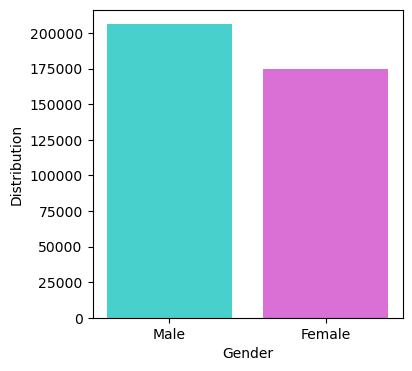

In [115]:
plt.figure(figsize=(4,4))
value_counts = train_df['Gender'].value_counts()
plt.bar(value_counts.index, value_counts.values, color=['mediumturquoise', 'orchid'])
plt.xlabel('Gender')
plt.ylabel('Distribution')
plt.show()

In [116]:
print(train_df['Vehicle_Age'].value_counts())

Vehicle_Age
1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: count, dtype: int64


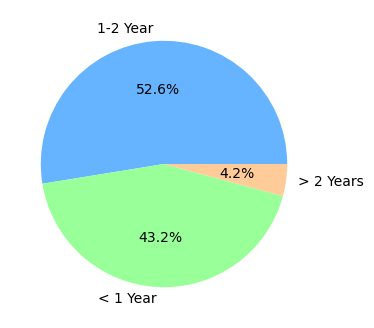

In [117]:
plt.figure(figsize=(4, 4))
plt.pie(train_df['Vehicle_Age'].value_counts(),labels=train_df['Vehicle_Age'].value_counts().index, autopct='%1.1f%%', colors=['#66b3ff', '#99ff99', '#ffcc99'])
plt.show()

In [118]:
print(train_df['Vehicle_Damage'].value_counts())

Vehicle_Damage
Yes    192413
No     188696
Name: count, dtype: int64


Convert the categorical feature to numeric

In [119]:
def convert_feature_to_binary(df, mapping_key, value:str):
    # Check if the column already contains 0 or 1 before mapping
    if not set(df[value]).issubset({0, 1}):
        df[value] = df[value].map(mapping_key)

In [120]:
gender_mapping = {'Female': 1, 'Male': 0}
convert_feature_to_binary(train_df, gender_mapping, 'Gender')
convert_feature_to_binary(test_df, gender_mapping, 'Gender')


In [121]:
Vehicle_mapping = {'Yes': 1, 'No': 0}
convert_feature_to_binary(train_df, Vehicle_mapping, 'Vehicle_Damage')
convert_feature_to_binary(test_df, Vehicle_mapping, 'Vehicle_Damage')

Handle with the categoric feature Vehicle_Age

In [126]:
encoder = OneHotEncoder(sparse=False, drop='first')  # drop='first' to get k-1 dummies out of k categorical levels
def encode_categoric_feature(df, feature):
    df_encoded_array = encoder.fit_transform(df[[feature]])

    # Create a DataFrame from the encoded array
    df_encoded = pd.DataFrame(df_encoded_array, columns=encoder.get_feature_names_out([feature]))
    df_encoded = df_encoded.astype(int)
    print(train_df_encoded)
    # Check if columns of train_df_encoded are in train_df
    if 'Vehicle_Age_< 1 Year' not in train_df.columns:
        train_df = pd.concat([train_df, train_df_encoded], axis=1)
        train_df = train_df.drop('Vehicle_Age', axis=1)

df_encoded_array = encoder.fit_transform(train_df[['Vehicle_Age']])

# Create a DataFrame from the encoded array
train_df_encoded = pd.DataFrame(df_encoded_array, columns=encoder.get_feature_names_out(['Vehicle_Age']))
train_df_encoded = train_df_encoded.astype(int)
print(train_df_encoded)
# Check if columns of train_df_encoded are in train_df
if 'Vehicle_Age_< 1 Year' not in train_df.columns:
    train_df = pd.concat([train_df, train_df_encoded], axis=1)
    train_df = train_df.drop('Vehicle_Age', axis=1)

        Vehicle_Age_< 1 Year  Vehicle_Age_> 2 Years
0                          0                      1
1                          0                      0
2                          0                      1
3                          1                      0
4                          1                      0
...                      ...                    ...
381104                     0                      0
381105                     1                      0
381106                     1                      0
381107                     0                      1
381108                     0                      0

[381109 rows x 2 columns]


In [127]:
train_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years
0,1,0,44,1,28.0,0,1,40454.0,26.0,217,1,0,1
1,2,0,76,1,3.0,0,0,33536.0,26.0,183,0,0,0
2,3,0,47,1,28.0,0,1,38294.0,26.0,27,1,0,1
3,4,0,21,1,11.0,1,0,28619.0,152.0,203,0,1,0
4,5,1,29,1,41.0,1,0,27496.0,152.0,39,0,1,0


In [62]:
test_df.head(10)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,0,25,1,11.0,1,< 1 Year,0,35786.0,152.0,53
1,381111,0,40,1,28.0,0,1-2 Year,1,33762.0,7.0,111
2,381112,0,47,1,28.0,0,1-2 Year,1,40050.0,124.0,199
3,381113,0,24,1,27.0,1,< 1 Year,1,37356.0,152.0,187
4,381114,0,27,1,28.0,1,< 1 Year,0,59097.0,152.0,297
5,381115,0,22,1,30.0,1,< 1 Year,0,40207.0,152.0,266
6,381116,1,51,1,37.0,1,1-2 Year,0,40118.0,26.0,107
7,381117,0,25,1,41.0,1,< 1 Year,0,23375.0,152.0,232
8,381118,0,42,1,41.0,0,1-2 Year,1,2630.0,26.0,277
9,381119,1,37,1,12.0,1,1-2 Year,0,27124.0,124.0,133
